# Regression modelling using multi-spectral aerial images: A case study using ``homnim``

This notebook shows how ``homonim`` can be used for improving regression modelling performance.  It works with multispectral aerial imagery and ground truth data from an [aboveground carbon (AGC) mapping study](https://github.com/dugalh/map_thicket_agc) that targeted the thicket biome in South Africa.  

The 4 band 50 cm aerial images were obtained from National Geospatial In

## Setup

In [1]:
# `matplotlib` and `geopandas` should be installed if they aren't already.
# import sys
# !{sys.executable} -m pip install matplotlib geopandas
# !conda install --yes --prefix {sys.prefix} -c conda-forge matplotlib geopandas

In [2]:
import logging
from pathlib import Path
from matplotlib import pyplot
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import numpy as np
from homonim import RasterFuse, RasterCompare, Model

logging.basicConfig(level=logging.ERROR)

Create an *images* sub-folder; and download & extract the [source aerial images](https://zenodo.org/record/7114702) into it.  It is a large download (~2 GB), so you may want to do it manually. Alternatively, run the code segment below.  

In [ ]:
url = 'https://zenodo.org/record/7114702/files/Ngi_May2015_Source.zip'
if False:
    import urllib
    import zipfile


    zip_path, _ = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall('ngi')
else:
    from os import fspath
    from pathlib import Path
    from shutil import copyfileobj
    from zipfile import ZipFile
    from tqdm.auto import tqdm  # could use from tqdm.gui import tqdm
    from tqdm.utils import CallbackIOWrapper
    import urllib

    dest = Path('images').expanduser()
    zip_path, _ = urllib.request.urlretrieve(url)
    with ZipFile(zip_path) as zipf, tqdm(
        desc='Downloading', unit="B", unit_scale=True, unit_divisor=1024,
        total=sum(getattr(i, "file_size", 0) for i in zipf.infolist()),
    ) as pbar:
        for i in zipf.infolist():
            if not getattr(i, "file_size", 0):  # directory
                zipf.extract(i, fspath(dest))
            else:
                with zipf.open(i) as fi, open(fspath(dest / i.filename), "wb") as fo:
                    copyfileobj(CallbackIOWrapper(pbar.update, fi), fo)

## Correct the aerial imagery to surface reflectance

### Search for a Sentinel-2 reference image

First we obtain a Sentinel-2 reference image using ``geedim``.  Normally we would search for a reference image that is concurrent with the aerial imagery, but the Sentinel-2 archive only starts after the capture date (25 May 2015).  So we search for the soonest possible reference after this date.  Thicket vegetation is slow growing, so there is unlikely to be much change between the source and reference capture dates.

In [3]:
src_mosaic_file = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')
import geedim as gd
from geedim.utils import get_bounds
gd.Initialize()
s2_coll = gd.MaskedCollection.from_name('COPERNICUS/S2')
region = gd.utils.get_bounds(src_mosaic_file)
s2_coll = s2_coll.search('2015-05-20', '2015-10-30', region)
print(s2_coll.schema_table)
print(s2_coll.properties_table)  

# equivalent geedim command line:
#!geedim search -c s2-toa -s 2015-10-20 -e 2015-10-30 -r {src_mosaic_file}

ABBREV     NAME                             DESCRIPTION
---------  -------------------------------  ---------------------------------------
ID         system:id                        Earth Engine image id
DATE       system:time_start                Image capture date/time (UTC)
FILL       FILL_PORTION                     Portion of valid pixels (%)
CLOUDLESS  CLOUDLESS_PORTION                Portion of cloud/shadow free pixels (%)
RADQ       RADIOMETRIC_QUALITY              Radiometric quality check
GEOMQ      GEOMETRIC_QUALITY                Geometric quality check
SAA        MEAN_SOLAR_AZIMUTH_ANGLE         Solar azimuth angle (deg)
SZA        MEAN_SOLAR_ZENITH_ANGLE          Solar zenith angle (deg)
VAA        MEAN_INCIDENCE_AZIMUTH_ANGLE_B1  View (B1) azimuth angle (deg)
VZA        MEAN_INCIDENCE_ZENITH_ANGLE_B1   View (B1) zenith angle (deg)
ID                                                   DATE             FILL CLOUDLESS RADQ   GEOMQ    SAA   SZA    VAA  VZA
-----------------

### Download a Sentinel-2 reference image

*COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH* is the first cloudless image, so let's download that.

In [4]:
ref_file = Path('images/s2_reference.tif')
gd_image = gd.MaskedImage.from_id('COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH', mask=True)
gd_image.download(ref_file, region=region, overwrite=True)

# equivalent geedim command line:
# !geedim download -i COPERNICUS/S2/20151023T081112_20151023T081949_T34HGH --mask -r {src_file}

s2_reference.tif: |          | 0.00/68.9M (raw) [  0.0%] in 00:00 (eta:     ?)

## Correct the aerial images to surface reflectance

Next, we fuse the aerial images with the Sentinel-2 reference, using ``homonim`` with a *gain-blk-offset* method, and kernel of 15 x 15 pixels.

In [5]:
from homonim import RasterFuse

src_files = [
    Path(f'images/3323d_2015_1001_02_00{i}_RGBN_CMP.tif') 
    for i in [76, 78, 80, 81]
]
# TODO: point the output files somewhere not in my onedrive
corr_files = [
    src_file.parent.joinpath(f'{src_file.stem}_FUSE.tif')
    for src_file in src_files
]
ref_bands = [4, 3, 2, 8]

for src_file, corr_file in zip(src_files, corr_files):
    corr_file = src_file.parent.joinpath(f'{src_file.stem}_FUSE.tif')

    with RasterFuse(
        src_file, ref_file, ref_bands=ref_bands
    ) as raster_fuse:
        raster_fuse.process(
            corr_file, Model.gain_blk_offset, (15, 15), overwrite=True,
        ) 

# TODO: lose the gdal warnings
# equivalent homonim command line:
# !homonim fuse -m gain-blk-offset -k 15 15 -rb 4 -rb 3 -rb 2 -rb 8 -mp -od images {src_file} {ref_file}

  0%|          |0/8 blocks [00:00<?]

  0%|          |0/32 blocks [00:00<?]

  0%|          |0/32 blocks [00:00<?]

  0%|          |0/32 blocks [00:00<?]

Next, we create a VRT mosaic of the corrected images to assist with visualisation and evaluation.

In [17]:
from osgeo import gdal

# strictly, one should avoid using GDAL and rasterio together, but it doesn't
# create conflicts here
corr_mosaic_file = Path('images/Corrected_Mosaic.vrt')
_ = gdal.BuildVRT(str(corr_mosaic_file), [str(cf) for cf in corr_files])
# TODO: sort error

## Evaluate 

The evaluation compares the correlation of source *NDVI* with AGC ground truth, and corrected *NDVI* with AGC ground truth.  This gives an indication of the improvement in the explanatory power, or accuracy, of NDVI due to surface reflectance correction.  

### Find source and corrected NDVI for each ground truth plot

Load the AGC ground truth into a ``GeoDataFrame``.

In [18]:
plot_agc_gdf = gpd.GeoDataFrame.from_file(
    'https://raw.githubusercontent.com/dugalh/map_thicket_agc/main/'
    'data/outputs/geospatial/gef_plot_polygons_with_agc_v2.gpkg' 
)

Next we find the mean source and corrected image NDVI values for each ground truth plot.

In [19]:
from rasterio import features
from rasterio import windows
from homonim import utils

src_mosaic_file = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')
src_mosaic_file = Path('images/Ngi_May2015_OrthoNgiDem_Source_Mosaic.vrt')

im_ndvis = []
for im_file in [src_mosaic_file, corr_mosaic_file]:
    ndvi = {}
    with rio.open(im_file, 'r') as ds:
        for id, plot in plot_agc_gdf.to_crs(ds.crs).iterrows():
            bounds = features.bounds(plot.geometry)
            win = windows.from_bounds(*bounds, transform=ds.transform)
            win = utils.expand_window_to_grid(win)
            array = ds.read(out_dtype='float64', window=win)

            win_transform = ds.window_transform(win)
            mask = features.geometry_mask(
                plot.geometry, (win.height, win.width), transform=win_transform
            )
            v = array[:, ~mask]
            ndvi[id] = np.mean((v[3] - v[0]) / (v[3] + v[0]))
    im_ndvis.append(ndvi)

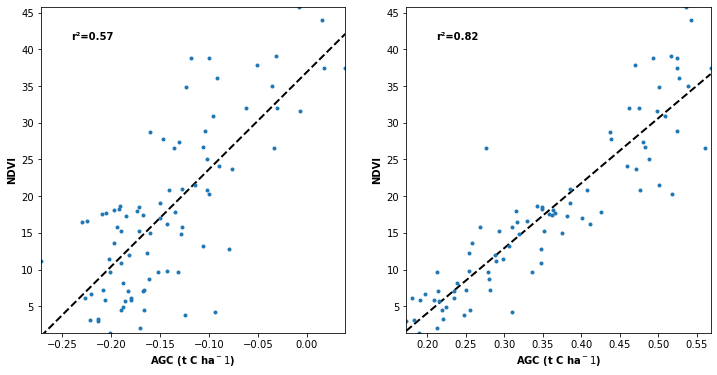

In [20]:
from matplotlib import pyplot


fig, axes = pyplot.subplots(1, 2, figsize=(12, 6))
agc = plot_agc_gdf.AgcHa / 1000
for ax, ndvi in zip(axes, im_ndvis):
    ndvi = np.array([*ndvi.values()])    # TODO: simplify
    ax.plot(ndvi, agc, '.')

    coeff, _, _, _ = np.linalg.lstsq(
        np.array([ndvi, np.ones(len(agc))]).T, agc
    )
    xlim = [np.nanmin(ndvi), np.nanmax(ndvi)]
    ylim = [np.nanmin(agc), np.nanmax(agc)]
    
    yr = np.array(xlim) * coeff[0] + coeff[1]
    ax.plot(xlim, yr, 'k--', lw=2, zorder=-1)
    
    r2 = np.corrcoef(agc, ndvi)[0, 1] **2
    ax.text(
        .1, 0.9, f'r\N{SUPERSCRIPT TWO}={r2:.2f}', fontweight='bold', 
        transform=ax.transAxes
    )
    ax.set_xlabel(f'AGC (t C ha$^{-1}$)', fontweight='bold')
    ax.set_ylabel(f'NDVI', fontweight='bold')
    ax.set_xlim(xlim)   # TODO: abbreviate x/ylim
    ax.set_ylim(ylim)
    
